In [1]:
#from lib import *

#set_stuff()

import numpy as np
from sklearn.decomposition import PCA
### Import 'arch'
import arch as arc
from arch import arch_model
from IPython.display import display, HTML

### Matplotlib imports
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates
from matplotlib import colors as mcolors
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()

### Import Pandas-related
import pandas as pd

from scipy.stats import beta, chi2, t, norm
import scipy.linalg
from scipy.linalg import toeplitz
import scipy.optimize
from scipy.optimize import minimize
import scipy.signal
import scipy as sp
import scipy.special
import scipy.stats

import yfinance as yf
import yahoofinancials
import time
from datetime import datetime

### statsmodels imports
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import multivariate
from statsmodels import regression
import scipy.stats as stats
from statsmodels.sandbox.regression import gmm
from statsmodels.sandbox.regression.gmm import GMM
import statsmodels.stats.diagnostic as smd
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.hypothesis_test_results import CausalityTestResults
from statsmodels.tsa.vector_ar.var_model import VAR, VARProcess, VARResults
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order

In [2]:
# Download the data
assets = ['^GSPC','GE']

# weirdly setting 1970 as the start date produces an error for me so let's 
# manually truncate it
data = yf.download(assets,end = datetime(2020,5,5),progress=True)#,auto_adjust=True)
# note setting auto adjust = true. This deals with stock splits the right way

data=data[data.index.year>=1970]
data = data['Close']
data.columns = ['GE','SP500']
data.head()

[*********************100%***********************]  2 of 2 completed


,GE,SP500
Date,,
1970-01-02,0.767478,93.000000
1970-01-05,0.763722,93.459999
1970-01-06,0.741186,92.820000
1970-01-07,0.744942,92.629997
1970-01-08,0.751202,92.680000


In [3]:
def ConstructReturns(data,frequency,deletePrices = False):
    toWork = data.copy()
    names = toWork.columns.values

    toWork['Year'] = toWork.index.year
    toWork['Month'] = toWork.index.month
    toWork['Day'] = toWork.index.day
    
    if frequency == 'monthly':
        ret_data = toWork.groupby(['Year','Month']).last()
        ret_data=ret_data.drop(columns=['Day'])
    elif frequency == 'annual':
        ret_data = toWork.groupby(['Year']).last()
        ret_data=ret_data.drop(columns=['Day','Month'])
    else:
        ret_data=data
    for nam in names:
        ret_data['Return_'+nam] = np.log(ret_data[nam]/ret_data[nam].shift(1)) # N.B log(1+r) is what I calculated
    
    #remove nans
    ret_data = ret_data[ret_data['Return_'+nam].notnull()]
        
    if deletePrices==True:
        ret_data=ret_data.drop(columns=names)
        ret_data.columns = names
    
        
    return ret_data
    
    

In [4]:
df_monthly = ConstructReturns(data,'monthly',deletePrices=True)
df_annual = ConstructReturns(data,'annual',deletePrices=True)
df_daily = ConstructReturns(data,'daily',deletePrices=True)

# Question 1

(a) Compute the autocorrelations of daily, monthly, and annual log returns up to lag 5.

In [5]:
# First some functions!
def createLags(df,varList,maxLag):
    # Function to take a dataframe and take maxLag lags for all data in varList. Do not use with panel data!
    laglist=[]
    for lag in range(maxLag):
        for var in varList:
            df[var+'_lag'+str(lag)]=df[var].shift(lag)
            laglist=laglist+[var+'_lag'+str(lag)]
            
    return df,laglist
    
def ols(Y,X,addConstant=True):
    if addConstant==True:
        X=sm.tools.add_constant(X)
    Y=np.matrix(Y).T
    X=np.matrix(X.values)
   
    XprimeX=X.T@X
    β = XprimeX.I@X.T@Y  # Calulate betahat
    return β.A1

def NeweyWest(Y,X,β_hat,Lags):
    Y=np.matrix(Y).T
    _,k=np.shape(X)
    if k<len(β_hat):
        X = sm.tools.add_constant(X)
    X=np.matrix(X)
    β_hat = np.matrix(β_hat).T
    ϵ=Y-X@β_hat
    
    # White Estimator
    
    XTϵ=np.matrix(X.T.A*ϵ.A1)  # element multiplication here is not a typo and annoyingly needs to be done on arrays
    XprimeX = X.T@X
    sandwich=XTϵ@XTϵ.T

    #Lagged addition
    for lags in range(1,Lags):
        # truncate matrixes
        T=np.shape(X)[0]
        Xlag = X[0:T-lags]
        Xpresent = X[lags:T]
        ϵPresent=ϵ[lags:T].A
        ϵLag=ϵ[0:T-lags].A
        Xpϵ=np.matrix(Xpresent.A*ϵPresent)
        Xlϵ=np.matrix(Xlag.A*ϵLag)
        
        sandwich = sandwich+(1-lags/(Lags+1))*(Xpϵ.T@Xlϵ+Xlϵ.T@Xpϵ)
        #new=(1-lags/(Lags+1))*(Xpϵ.T@Xlϵ+Xlϵ.T@Xpϵ)
        #print(new)

        
    var_β = XprimeX.I@sandwich@XprimeX.I
    return var_β

def acf(df,varName,maxLag):
    ρ_hat=[0.0 for l in range(maxLag)]
    se_ρ=[0.0 for l in range(maxLag)]
    for lag in range(maxLag):
        dfuse=df[df[varName+'_lag'+str(lag)].notnull()]
        T=np.shape(dfuse)[0]
        β_hat = ols(dfuse[varName],dfuse[varName+'_lag'+str(lag)])
        ρ_hat[lag] = β_hat[1] # ignore constant estimate
        se_ρ[lag] = 0 if lag==0 else (1/(T-lag))**(0.5) # standard error is 1/sqrt(T) where T is length of data used in ACF calculation
        
    return ρ_hat,se_ρ


def plotACF(ax,varNames,plotName,df_orig,maxLags,xlabel):
    df=df_orig.copy()
    df,_=createLags(df,varNames,maxLags+1)
    

    plotCount=0
    for var in varNames:
        ρ_acf,se_acf=acf(df,var,maxLags+1)
        ax[plotCount].plot(range(maxLags+1),ρ_acf)
        ax[plotCount].fill_between(range(maxLags+1), 1.96*np.array(se_acf), -1.96*np.asarray(se_acf),facecolor=(0.8,0.8,0.8),alpha=0.5)
        
        #ax[plotCount].errorbar(range(maxLags+1),[0]*(maxLags+1),yerr=1.96*np.array(se_acf),color='black',marker='.',linestyle='none')
        ax[plotCount].set_title('ACF of '+plotName[plotCount]+' at '+xlabel+' frequency',fontsize=20)
        ax[plotCount].set_xlabel(xlabel)
        ax[plotCount].set_xticks(range(0,maxLags+1))
        plotCount+=1
        

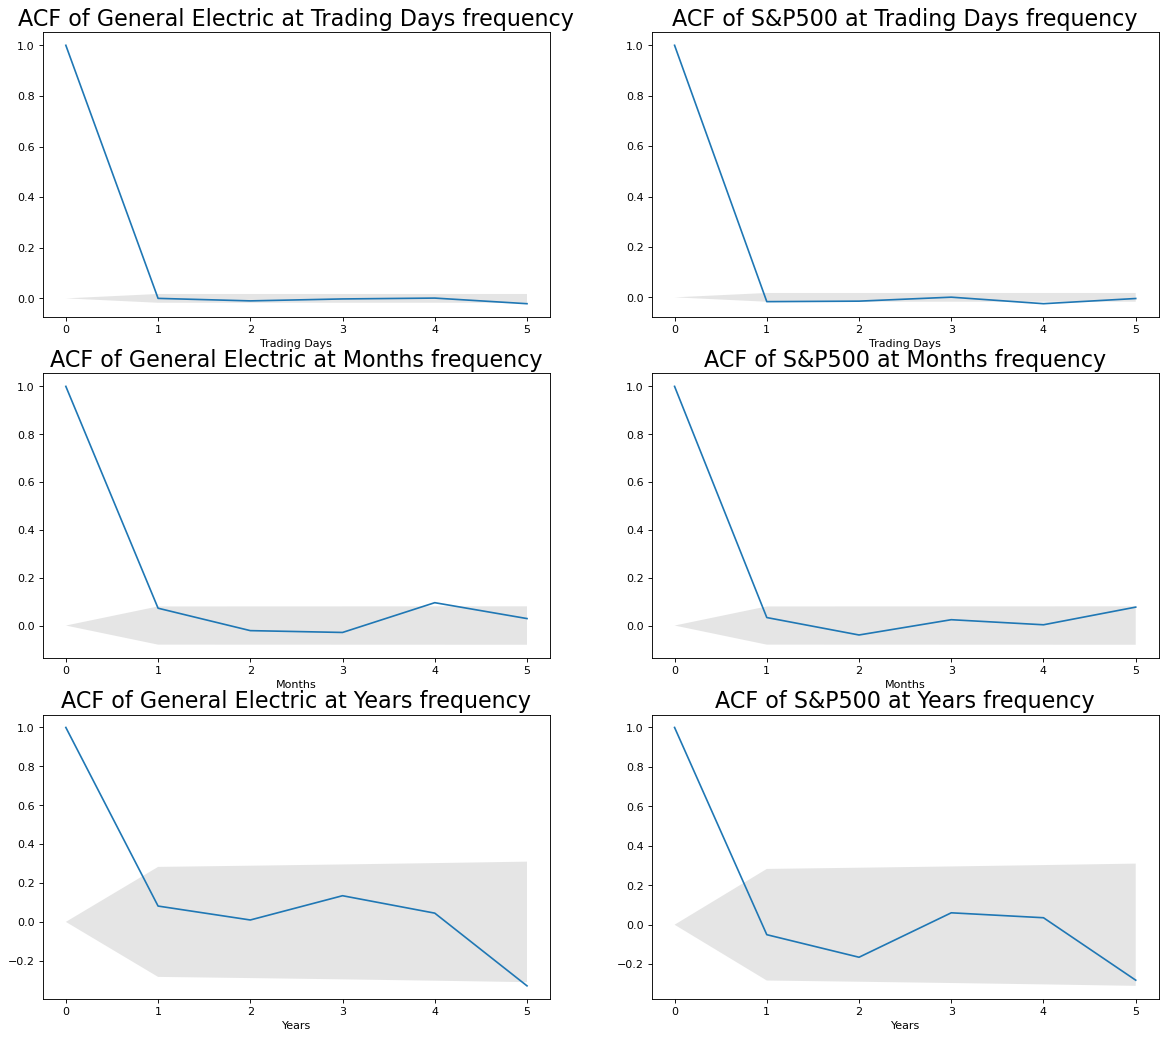

In [6]:
# And now some output!
fig,ax =  plt.subplots(3,2,figsize=(18, 16), dpi= 80)
plotACF(ax[0],['GE','SP500'],['General Electric','S&P500'],df_daily,5,'Trading Days')
plotACF(ax[1],['GE','SP500'],['General Electric','S&P500'],df_monthly,5,'Months')
plotACF(ax[2],['GE','SP500'],['General Electric','S&P500'],df_annual,5,'Years')

> *An intresting thing is going on here! The series are becoming more autocorrelated as we go to lower frequencies (albeit not as fast as standard errors are rising)! This might seem puzzling given that we would think an AR(1) with persistence of 0.5 at the annual level should exhibit a **lot** more persistence at the daily level. What is happening here is something well known with "temporal aggreation": summing across time introduces MA terms into an AR process. Below is an example going from monthly to quarterly:*
> $$
\begin{aligned}
\log p_{m,t} &= \phi \log p_{m,t-1}+\epsilon_t\\
r_{m,t} &= \log p_t - \log p_{m,t-1} = (\phi-1)\log p_{t-1}+\epsilon_t\\
r_{q,t} &=  r_{m,t}+ r_{m,t-1}+r_{m,t-2} = \log p_{m,t} - \log p_{m,t-2} = (\phi^2-1)\log p_{m,t-2}+\epsilon_t+\phi \epsilon_{t-1}
\end{aligned}
$$
> *You can see in this simple example that going to quarterly returns has made the process an ARMA process. Something like this is what is driving the increases in autocorrelation we are observing by aggregating to a lower frequency!*

(b) Compute the average volatility over the sample using the following volatility measures (all
expressed in annual units):

   i. Average annualized volatility of daily returns.

   ii. Average annualized volatility of monthly returns.

   iii. Average volatility of annual returns.
   
   Why are the sample averages different?

In [7]:
volatilities=pd.DataFrame(df_daily.std()*np.sqrt(252))
volatilities.columns=['Daily Frequency']
volatilities['Monthly Frequency'] = df_monthly.std()*np.sqrt(12)


volatilities['Annual Frequency']=df_annual.std()
volatilities

,Daily Frequency,Monthly Frequency,Annual Frequency
GE,0.278056,0.256307,0.312357
SP500,0.172431,0.153030,0.168415


> *As can be seen here the monthly and daily volatility calculations are similar but not identical. The annual volatility calculations for GE are considerably higher but not for the S&P500. How can this be? It seems that returns at the monthly frequency for GE are likely **positively** correlated. This means that movements over 2 months if month 1 has a good return, then month 2 will as well. This makes returns from year to year vary a lot more than they do month to month. As an example consider the following two processes:*
> $$
\begin{aligned}
x_t^m&={3,-3,0,3,-3,0,3,-3,0,\dots}\Rightarrow var(x_t)=2*9/3=6\\
y_t^m&={3,3,3,-3,-3,-3,0,0,0,\dots}\Rightarrow var(y_t)=2*9/3=6
\end{aligned}
$$
> *If we aggreate $x_t$ and $y_t$ to qaurterly we get:*
> $$
\begin{aligned}
x_t^q&={0,0,0,0,0,0,0,0,0,\dots}\Rightarrow var(x_t)=0\\
y_t^q&={9,-9,0,9,-9,0,\dots}\Rightarrow var(y_t)=2*81/3=54
\end{aligned}
$$
> *Here $x_t$ is **negatively** correlated within a quarter to that surprise returns cancel out. $y_t$ has *positively* correlated returns within a quarter so that surprise returns within a quarter get **bigger**. This is likely what is happening for GE when we aggregate from monthly to annual. You can see some evidence of this on the ACF graph for GE above (and you don't see the positive correlation on the S&P500 ACF.* 

(c) Next, compare the time series of

i. Volatility of monthly returns.

ii. Monthly volatility based on daily returns in each month.

Plot these monthly series and compute their means, variances and correlation.

> *Before I answer this, let me say that there was a lot of confusion about how to interpret i. I am going to interpret it as simply squaring the monthly returns. I imagine many of you had different interpretations and that is fine. Main thing is to get a time series.*

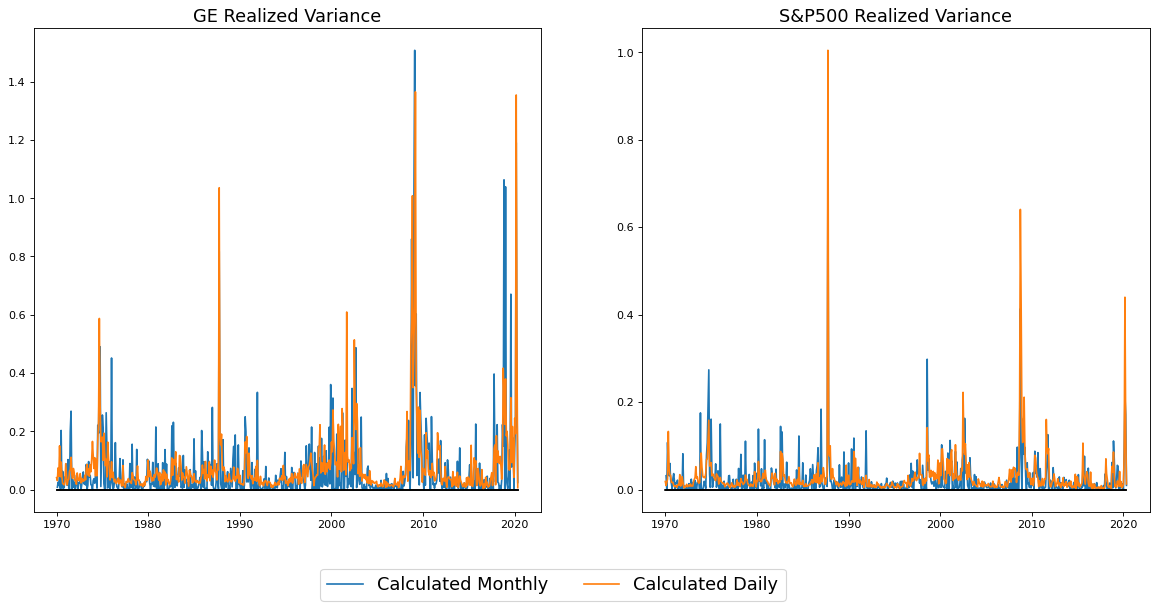

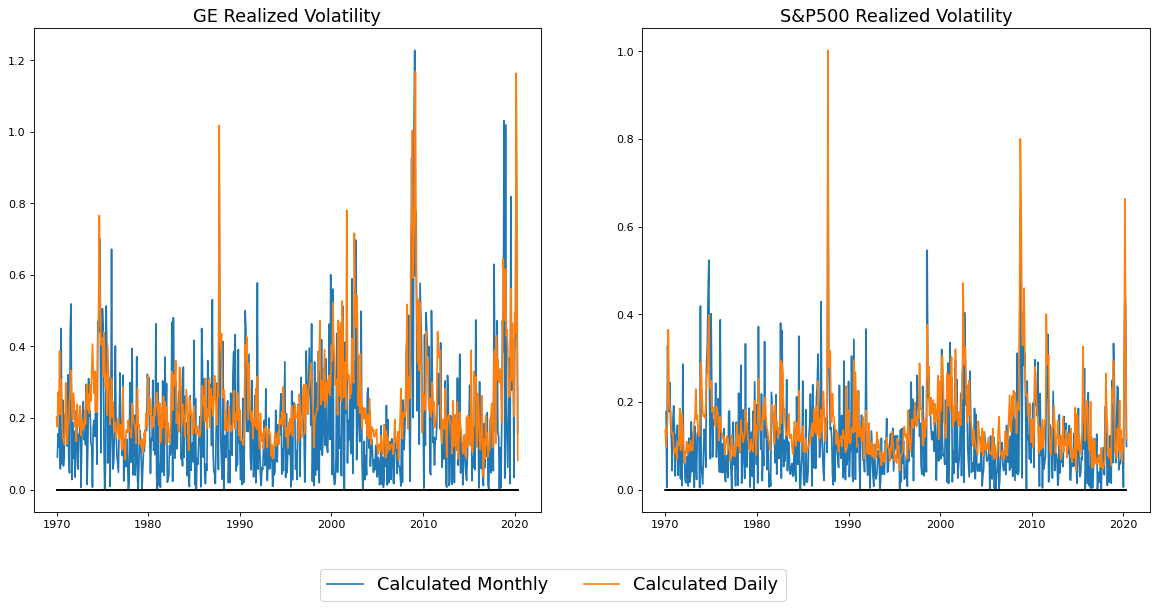

In [8]:

#square returns
names=df_daily.columns
for nam in names:
    df_monthly[nam+'^2'] = df_monthly[nam]**2*12  # scale by 12 to bring to annual variance terms
    #df_monthly[nam]=df_monthly[nam]*np.sqrt(12)
    df_daily[nam+'^2'] = df_daily[nam]**2*12
    df_daily[nam+'_acf'] = df_daily[nam]*df_daily[nam].shift(1)*12
    df_daily['Year'] = df_daily.index.year
    df_daily['Month'] = df_daily.index.month
df_RealizedVol = df_daily.groupby(['Year','Month']).sum()
for nam in names:
    df_RealizedVol[nam+'^2'] = df_RealizedVol[nam+'^2']+df_RealizedVol[nam+'_acf']
    df_RealizedVol=df_RealizedVol.drop(columns=[nam+'_acf'])
df_RealizedVol=df_RealizedVol.drop(columns=names)

for nam in names:
    df_daily=df_daily.drop(columns=[nam+'^2'])
df_daily=df_daily.drop(columns=['Year','Month'])


# annoying formatting 
df_monthly=df_monthly.reset_index()
df_monthly['Date'] = pd.to_datetime(df_monthly['Year'].astype(str)+'-'+df_monthly['Month'].astype(str)+'-01')
df_monthly=df_monthly.set_index('Date')
df_monthly.drop(columns = ['Year','Month'])

df_RealizedVol=df_RealizedVol.reset_index()
df_RealizedVol['Date'] = pd.to_datetime(df_RealizedVol['Year'].astype(str)+'-'+df_RealizedVol['Month'].astype(str)+'-01')
df_RealizedVol=df_RealizedVol.set_index('Date')
df_RealizedVol.drop(columns = ['Year','Month'])

# plot them over time
fig,ax =  plt.subplots(1,2,figsize=(18, 8), dpi= 80)
ax[0].plot(df_monthly.index,df_monthly['GE^2'],label='Calculated Monthly')
ax[0].plot(df_monthly.index,0*df_monthly['GE^2'],color='black',label = '_nolegend_')
ax[0].set_title('GE Realized Variance',fontsize=16)
ax[1].plot(df_monthly.index,df_monthly['SP500^2'],label='Calculated Monthly')
ax[1].plot(df_monthly.index,0*df_monthly['SP500^2'],color='black',label = '_nolegend_')
ax[1].set_title('S&P500 Realized Variance',fontsize=16)

ax[0].plot(df_RealizedVol.index,df_RealizedVol['GE^2'],label = 'Calculated Daily')
ax[0].plot(df_RealizedVol.index,0*df_RealizedVol['GE^2'],color='black',label = '_nolegend_')

ax[1].plot(df_RealizedVol.index,df_RealizedVol['SP500^2'],label = 'Calculated Daily')
ax[1].plot(df_RealizedVol.index,0*df_RealizedVol['SP500^2'],color='black',label = '_nolegend_')

ax[0].legend(bbox_to_anchor=(1.5, -0.1),ncol=2,fontsize=16)
plt.show()

# plot volatility instead of variance
fig,ax =  plt.subplots(1,2,figsize=(18, 8), dpi= 80)
ax[0].plot(df_monthly.index,df_monthly['GE^2']**(0.5),label='Calculated Monthly')
ax[0].plot(df_monthly.index,0*df_monthly['GE^2']**(0.5),color='black',label = '_nolegend_')
ax[0].set_title('GE Realized Volatility',fontsize=16)
ax[1].plot(df_monthly.index,df_monthly['SP500^2']**(0.5),label='Calculated Monthly')
ax[1].plot(df_monthly.index,0*df_monthly['SP500^2']**(0.5),color='black',label = '_nolegend_')
ax[1].set_title('S&P500 Realized Volatility',fontsize=16)

ax[0].plot(df_RealizedVol.index,df_RealizedVol['GE^2']**(0.5),label = 'Calculated Daily')
ax[0].plot(df_RealizedVol.index,0*df_RealizedVol['GE^2']**(0.5),color='black',label = '_nolegend_')

ax[1].plot(df_RealizedVol.index,df_RealizedVol['SP500^2']**(0.5),label = 'Calculated Daily')
ax[1].plot(df_RealizedVol.index,0*df_RealizedVol['SP500^2']**(0.5),color='black',label = '_nolegend_')

ax[0].legend(bbox_to_anchor=(1.5, -0.1),ncol=2,fontsize=16)
plt.show()

> *Note that everything here has been converted to annual volatility or variance equivalents. It seems here that both are related by that the monthly series appears to be much noisier (which since it is a. based on 1 observation and 2. not demeaned is unsurprising). Note that the monthly estimate is on average $\sigma^2+\mu^2$ whereas the daily is on average $\sigma^2+\frac{\mu^2}{m}$ where $r_t\sim N(\mu,\sigma^2)$.*
>
> *Despite this, the daily calculated series is much higher on average than monthly! There is a lot of within day variances in returns that are not visible at the monthly level. Cool!
*

In [9]:
df_RVol = pd.merge(df_RealizedVol,df_monthly,on='Date')
df_RVol=df_RVol.drop(columns=['Year_x','Month_x','GE','SP500','Year_y','Month_y'])
df_RVol = df_RVol[['GE^2_x','GE^2_y','SP500^2_x','SP500^2_y']]
df_RVol.columns=['RVOL(GE)_daily','RVOL(GE)_monthly','RVOL(S&P500)_daily','RVOL(S&P500)_monthly']

In [10]:
stats_Rvol = pd.DataFrame(df_RVol.mean())
stats_Rvol.columns=['E[RVol]']
stats_Rvol['Var(RVol)'] = df_RVol.var()
stats_Rvol

,E[RVol],Var(RVol)
RVOL(GE)_daily,0.077325,0.015196
RVOL(GE)_monthly,0.065743,0.019455
RVOL(S&P500)_daily,0.029257,0.003505
RVOL(S&P500)_monthly,0.023783,0.002342


In [11]:
df_RVol.corr()

,RVOL(GE)_daily,RVOL(GE)_monthly,RVOL(S&P500)_daily,RVOL(S&P500)_monthly
RVOL(GE)_daily,1.000000,0.650875,0.759047,0.562881
RVOL(GE)_monthly,0.650875,1.000000,0.502372,0.575831
RVOL(S&P500)_daily,0.759047,0.502372,1.000000,0.778277
RVOL(S&P500)_monthly,0.562881,0.575831,0.778277,1.000000


> *The daily and monthly series for GE and the S&P500 have similar means although the daily is larger than the monthly. We saw this in the graphs too. Variances show a similar pattern across both too.*
> *In terms of correlations, the S&P500 and GE meaures are quite correlated but also the daily measures of the different stocks are quite correlated (more so than the correlation of GE monthly and GEdaily!) Interesting!*

(d) Estimate an AR(1) model for realized monthly volatility. What features of the data and
model are noteworthy?

In [12]:
def rsquared(Y,X,β):
    Y=np.matrix(Y).T
    _,k=np.shape(X)
    if k<len(β):
        X = sm.tools.add_constant(X)
    X=np.matrix(X)
    ϵ=Y-X@np.matrix(β).T
    σ2=ϵ.T@ϵ
    Yσ2 = (Y.T-np.mean(Y))@(Y-np.mean(Y))
    R2 = 1-σ2/Yσ2
    return R2

def niceOLS(df,Yname,Xlist,errorType,addConstant=True):
    # Produce OLS with my own functions but also print nice output. 
    # Note do do newey west please enter a tuple of ("NeweyWest",lag#) or ("HAC",lag#) or ("NW",lag#)
    
    dfuse=df[df[Xlist[len(Xlist)-1]].notnull()]  # remove nans
    Y=dfuse[Yname]
    X=dfuse[Xlist]
    β=ols(Y,X,addConstant)
    
    # standard errors
    if errorType=="Homoskedastic":
        ses = homoskedasticSES(Y,X,β)
    elif (errorType=="Heteroskedastic")|(errorType=="White")|(errorType=="Het"):
        ses = np.diag(np.sqrt(NeweyWest(Y,X,β,0)))  #as I coded above this function does White for lag=0
    elif len(errorType)==1:
        error("wrong entry of standard error")
    elif (errorType[0]=="NeweyWest")|(errorType[0]=="NW")|(errorType[0]=="HAC"):
        NWlags=errorType[1]
        ses = np.diag(np.sqrt(NeweyWest(Y,X,β,NWlags)))  #as I coded above this function does White for lag=0
        
    # I am going to only do the R^2 and t-stats for ''standard'' output. Sorry
    explained = np.matrix(X)
    R2=rsquared(Y,X,β)
    tstat=β/ses
    pvalue = (1-stats.norm.cdf(np.abs(tstat)))*2
    
    # print output
    print("Name      ","    β  "," s.e.",'  Tstat',' P-value')
    if addConstant==True:
        print("Constant    "," {:.3f}".format(β[0]),"{:.3f}".format(ses[0])," {:.3f}".format(tstat[0])," {:.3f}".format(pvalue[0]))
    for i in range(addConstant,len(β)):
        print(Xlist[i-1]," {:.3f}".format(β[i]),"{:.3f}".format(ses[i])," {:.3f}".format(tstat[i])," {:.3f}".format(pvalue[i]))

    print("R^2 is:", "{:.3f}".format(np.squeeze(R2.A1[0])))
    
    return β,ses,Y,X

AR(1) GE
Name           β    s.e.   Tstat  P-value
Constant      0.038 0.007  5.527  0.000
GE^2_lag1  0.505 0.111  4.535  0.000
R^2 is: 0.255
************************************************
AR(1) S&P500
Name           β    s.e.   Tstat  P-value
Constant      0.019 0.004  4.606  0.000
SP500^2_lag1  0.358 0.149  2.397  0.017
R^2 is: 0.128


C:\Users\Nick\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


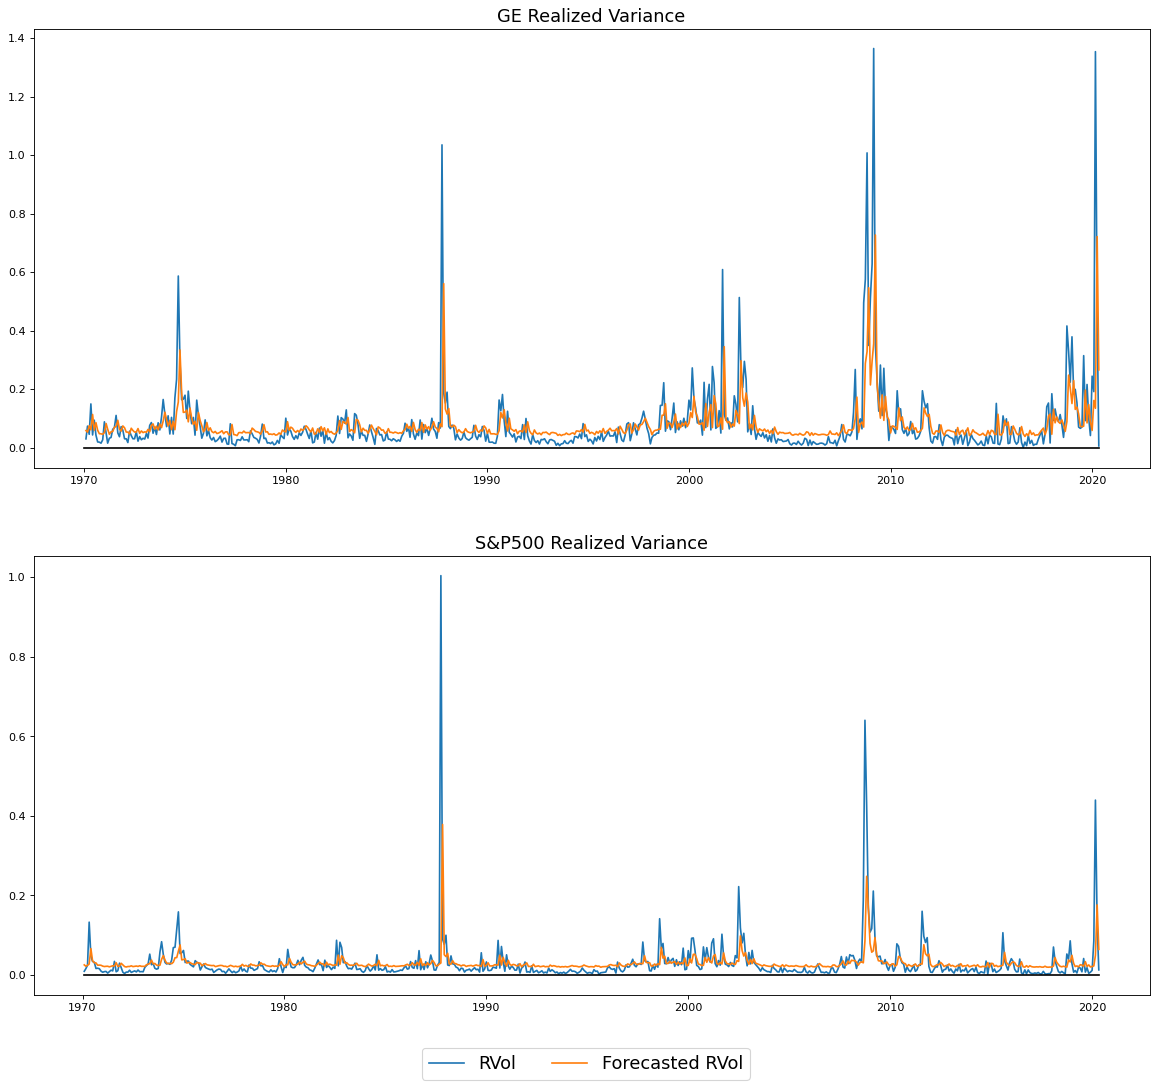

In [13]:
df_RealizedVol,_ =  createLags(df_RealizedVol,['GE^2','SP500^2'],2)   
varList=['GE^2_lag1']
Ylist='GE^2'
print("AR(1) GE")
β_GE,_,Y_GE,X_GE=niceOLS(df_RealizedVol,Ylist,varList,'Het')
print('************************************************')
print("AR(1) S&P500")
varList=['SP500^2_lag1']
Ylist='SP500^2'
β_SP,_,Y_SP,X_SP=niceOLS(df_RealizedVol,Ylist,varList,'Het')

X_GE = sm.add_constant(X_GE)
X_SP = sm.add_constant(X_SP)

# plot them over time
fig,ax =  plt.subplots(2,1,figsize=(18, 16), dpi= 80)
ax[0].plot(df_monthly.index,Y_GE,label='RVol')
ax[0].plot(df_monthly.index,np.matrix(X_GE)@np.matrix(β_GE).T,label='Forecasted RVol')
ax[0].plot(df_RealizedVol.index,0*df_RealizedVol['GE^2'],color='black',label = '_nolegend_')
ax[0].set_title('GE Realized Variance',fontsize=16)
ax[1].plot(df_monthly.index,Y_SP,label='RVol')
ax[1].plot(df_monthly.index,np.matrix(X_SP)@np.matrix(β_SP).T,label='Forecasted RVol')
ax[1].plot(df_monthly.index,0*df_monthly['SP500^2'],color='black',label = '_nolegend_')
ax[1].set_title('S&P500 Realized Variance',fontsize=16)

ax[1].legend(bbox_to_anchor=(0.65, -0.1),ncol=2,fontsize=16)
plt.show()

AR(1) GE
Name           β    s.e.   Tstat  P-value
Constant      0.038 0.007  5.527  0.000
GE^2_lag1  0.505 0.111  4.535  0.000
R^2 is: 0.255
************************************************
AR(1) S&P500
Name           β    s.e.   Tstat  P-value
Constant      0.019 0.004  4.606  0.000
SP500^2_lag1  0.358 0.149  2.397  0.017
R^2 is: 0.128


C:\Users\Nick\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


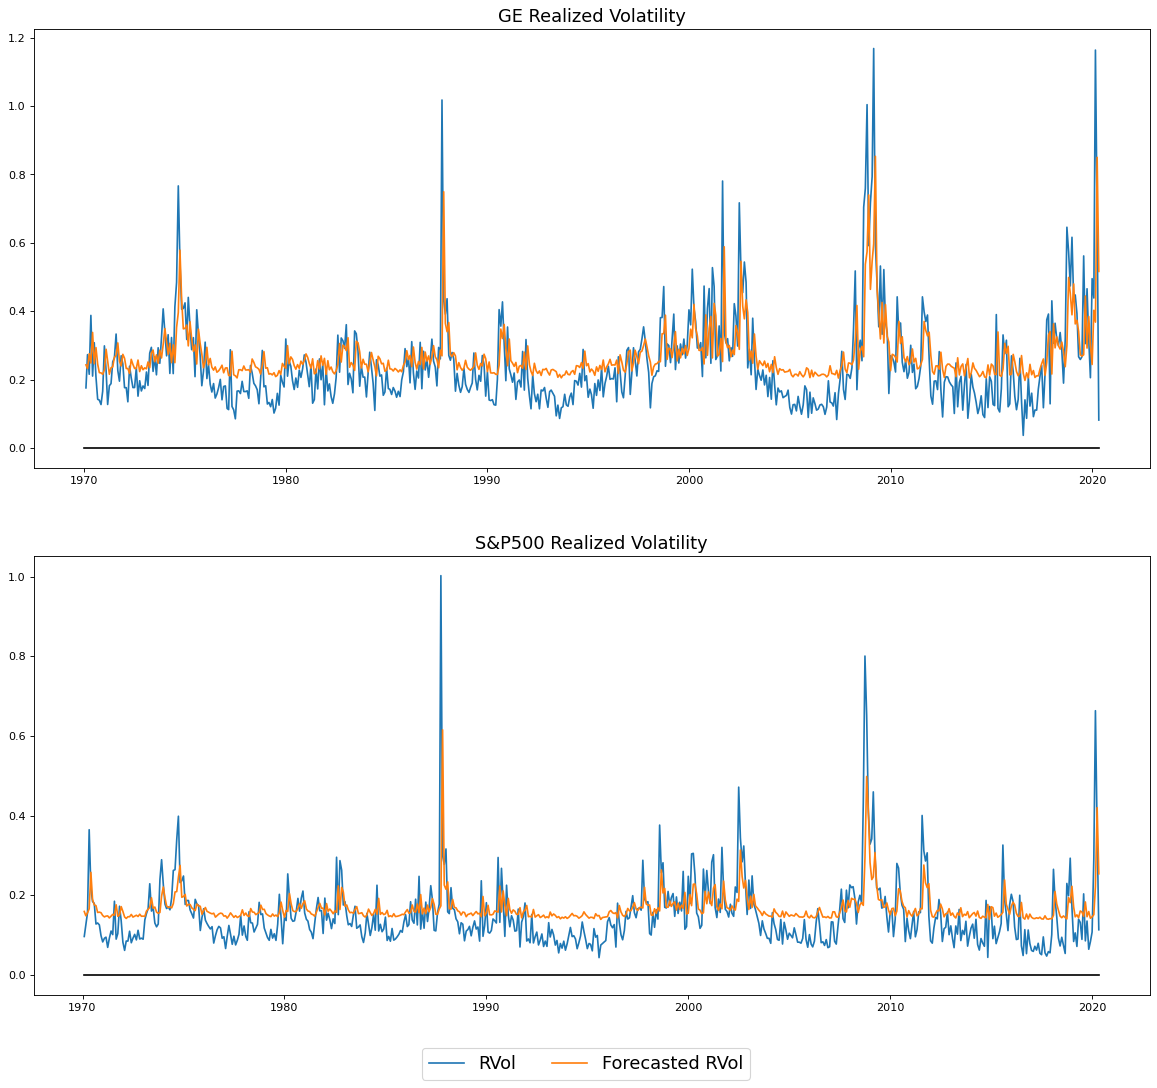

In [14]:
df_RealizedVol,_ =  createLags(df_RealizedVol,['GE^2','SP500^2'],2)   
varList=['GE^2_lag1']
Ylist='GE^2'
print("AR(1) GE")
β_GE,_,Y_GE,X_GE=niceOLS(df_RealizedVol,Ylist,varList,'Het')
print('************************************************')
print("AR(1) S&P500")
varList=['SP500^2_lag1']
Ylist='SP500^2'
β_SP,_,Y_SP,X_SP=niceOLS(df_RealizedVol,Ylist,varList,'Het')

X_GE = sm.add_constant(X_GE)
X_SP = sm.add_constant(X_SP)

# plot them over time
fig,ax =  plt.subplots(2,1,figsize=(18, 16), dpi= 80)
ax[0].plot(df_monthly.index,Y_GE**(0.5),label='RVol')
ax[0].plot(df_monthly.index,(np.matrix(X_GE)@np.matrix(β_GE).T).A1**(0.5),label='Forecasted RVol')
ax[0].plot(df_RealizedVol.index,0*df_RealizedVol['GE^2'],color='black',label = '_nolegend_')
ax[0].set_title('GE Realized Volatility',fontsize=16)
ax[1].plot(df_monthly.index,(Y_SP)**(0.5),label='RVol')
ax[1].plot(df_monthly.index,(np.matrix(X_SP)@np.matrix(β_SP).T).A1**(0.5),label='Forecasted RVol')
ax[1].plot(df_monthly.index,0*df_monthly['SP500^2'],color='black',label = '_nolegend_')
ax[1].set_title('S&P500 Realized Volatility',fontsize=16)

ax[1].legend(bbox_to_anchor=(0.65, -0.1),ncol=2,fontsize=16)
plt.show()

> *Interesting, the ARCH model has a lower bound that is very high for the GE realized volatility. You can see there is the same issue for the S&P500 volatility. I suspect a GARCH model could get around this issue better. Other noteworthy features are that the volatility predicted by the ARCH(1) is much lower than Realized volatility -- especially in spikes. Secondly you can see that it is more persistent that RVol too.*

In [15]:
resid_GE = np.matrix(Y_GE).T-np.matrix(X_GE)@np.matrix(β_GE).T
RMSE_GE=np.sqrt(resid_GE.T@resid_GE/np.max(np.shape(resid_GE)))
resid_SP = np.matrix(Y_SP).T-np.matrix(X_SP)@np.matrix(β_SP).T
RMSE_SP=np.sqrt(resid_SP.T@resid_SP/np.max(np.shape(resid_GE)))

# Needed later
MAE_GE = np.mean(np.abs(resid_GE))
MAE_SP = np.mean(np.abs(resid_SP))

print('RMSE_GE','   RMSE_SP')
print('{:.4f}'.format(RMSE_GE.A1[0]),'    {:.4f}'.format(RMSE_SP.A1[0]))

RMSE_GE    RMSE_SP
0.1063     0.0552


> *These RMSE are in units of annual volatility missed. So for the S&P500 - the ARCH(1) model misses volatility of 20%! This is equivalent to the annual average volatility of the S&P500 -- huge! For GE the RMSE is even larger but also the overall volatility of GE is higher too. Still though the ARCH(1) model is not fitting well!*

# Question 2
(a) Estimate a GARCH(1,1) model for monthly returns. What features of the data and model
are noteworthy?

In [18]:
%%capture
am = arc.arch_model(df_monthly['GE'],vol='Garch',p=1,q=1,dist='normal',mean='ARX',lags=[1])
res_GE=am.fit()


In [19]:
print(res_GE.summary())


                           AR - GARCH Model Results                           
Dep. Variable:                     GE   R-squared:                      -0.005
Mean Model:                        AR   Adj. R-squared:                 -0.006
Vol Model:                      GARCH   Log-Likelihood:                769.168
Distribution:                  Normal   AIC:                          -1528.34
Method:            Maximum Likelihood   BIC:                          -1506.33
                                        No. Observations:                  603
Date:                Thu, May 14 2020   Df Residuals:                      598
Time:                        15:56:46   Df Model:                            5
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      7.7537e-03  2.677e-03      2.896  3.777e-03 

> *Ok, we have a model where there is:*
> 1. *Very little persistence ($\mu$ is small) which is what we would expect with returns*
> 2. *There is a strong GARCH term -- 0.83 which is highly significant.*
> 3. *The ARCH term and constant in the volatility model are also highly significant!*
> 4. *The R^2 is negative!?! How is this possible? Have a look at what we get if I estimate an AR(1) model:*

In [20]:
df_monthly,_ =  createLags(df_monthly,['GE','SP500'],2)   
varList=['GE_lag1']
Ylist='GE'
β_SP2,_,Y_SP2,X_SP2=niceOLS(df_monthly,Ylist,varList,'Het',addConstant=True)


Name           β    s.e.   Tstat  P-value
Constant      0.003 0.003  1.106  0.269
GE_lag1  0.072 0.059  1.220  0.223
R^2 is: 0.005


C:\Users\Nick\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


> *I run an AR(1) with vs. without a constant because it is not clear whether GARCH includes a constant in the mean equation. However what is clear is that the AR(1) coefficient estimated with OLS is larger than with GARCH. Why is this? Well in Garch, the estimation is done with MLE meaning that all paramters are chosen to max the likelihood. And with Garch, the likelihood is trying to match two types of moments: the mean **and the variance**. To match the time variation in the variance of monthly returns, the AR(1) term in the mean equation is being distorted! Then the R^2 is calculated **only** in reference to the mean equation and gets worse!*
>
> *Let's now look at the S&P500 model*



In [21]:
%%capture
am = arc.arch_model(df_monthly['GE'],vol='Garch',p=1,q=1,dist='normal',mean='ARX',lags=[1])
res_GE=am.fit()


In [22]:
print(res_GE.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                     GE   R-squared:                      -0.005
Mean Model:                        AR   Adj. R-squared:                 -0.006
Vol Model:                      GARCH   Log-Likelihood:                769.168
Distribution:                  Normal   AIC:                          -1528.34
Method:            Maximum Likelihood   BIC:                          -1506.33
                                        No. Observations:                  603
Date:                Thu, May 14 2020   Df Residuals:                      598
Time:                        15:57:05   Df Model:                            5
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      7.7537e-03  2.677e-03      2.896  3.777e-03 

In [23]:
%%capture
am = arc.arch_model(df_monthly['SP500'],vol='Garch',p=1,q=1,dist='normal',mean='ARX',lags=[1])
res_SP=am.fit()



In [24]:
print(res_SP.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                  SP500   R-squared:                      -0.001
Mean Model:                        AR   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:                1049.34
Distribution:                  Normal   AIC:                          -2088.68
Method:            Maximum Likelihood   BIC:                          -2066.67
                                        No. Observations:                  603
Date:                Thu, May 14 2020   Df Residuals:                      598
Time:                        15:57:15   Df Model:                            5
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       6.6248e-03  1.779e-03      3.724  1.959e

> *The results are similar in a sense to the GE model. Note the negative AR term. That is weird from the perspective of only running an OLS regression and note the negative R^2 as a consequence.*

(b) Regress realized monthly volatility on conditional GARCH(1,1) volatility. Plot realized
volatility and conditional volatility.

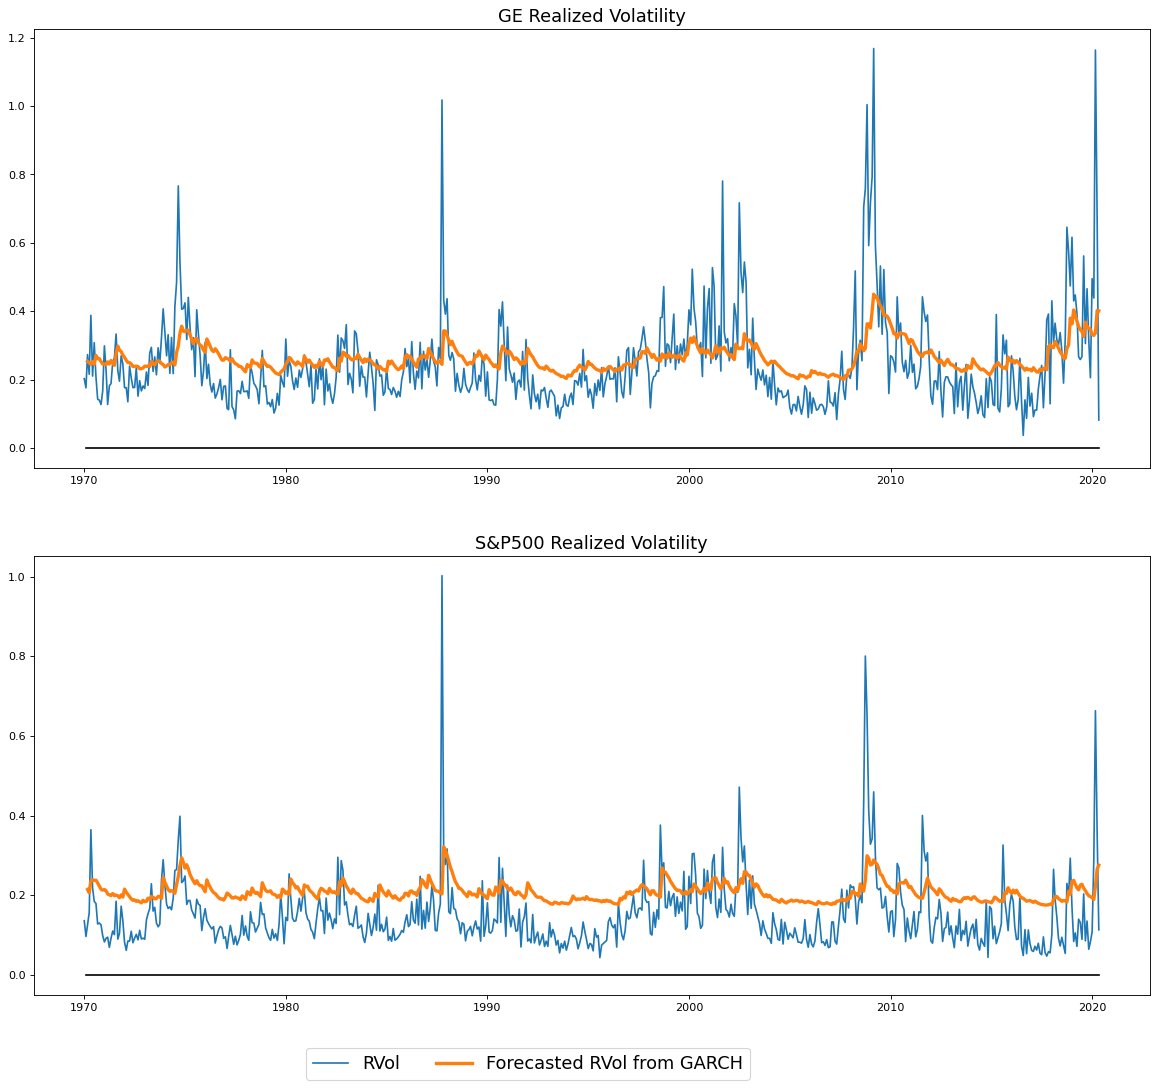

In [25]:

# plot them over time
fig,ax =  plt.subplots(2,1,figsize=(18, 16), dpi= 80)
ax[0].plot(df_RealizedVol.index,df_RealizedVol['GE^2']**(0.5),label='RVol')
ax[0].plot(res_GE.conditional_volatility**(0.5),label='Forecasted RVol from GARCH',linewidth=3)
ax[0].plot(df_monthly.index,0*df_monthly['GE^2'],color='black',label = '_nolegend_')
ax[0].set_title('GE Realized Volatility',fontsize=16)
ax[1].plot(df_RealizedVol.index,df_RealizedVol['SP500^2']**(0.5),label='RVol')
ax[1].plot(res_SP.conditional_volatility**(0.5),label='Forecasted RVol from GARCH',linewidth=3)
ax[1].plot(df_monthly.index,0*df_monthly['SP500^2'],color='black',label = '_nolegend_')
ax[1].set_title('S&P500 Realized Volatility',fontsize=16)

ax[1].legend(bbox_to_anchor=(0.65, -0.1),ncol=2,fontsize=16)
plt.show()

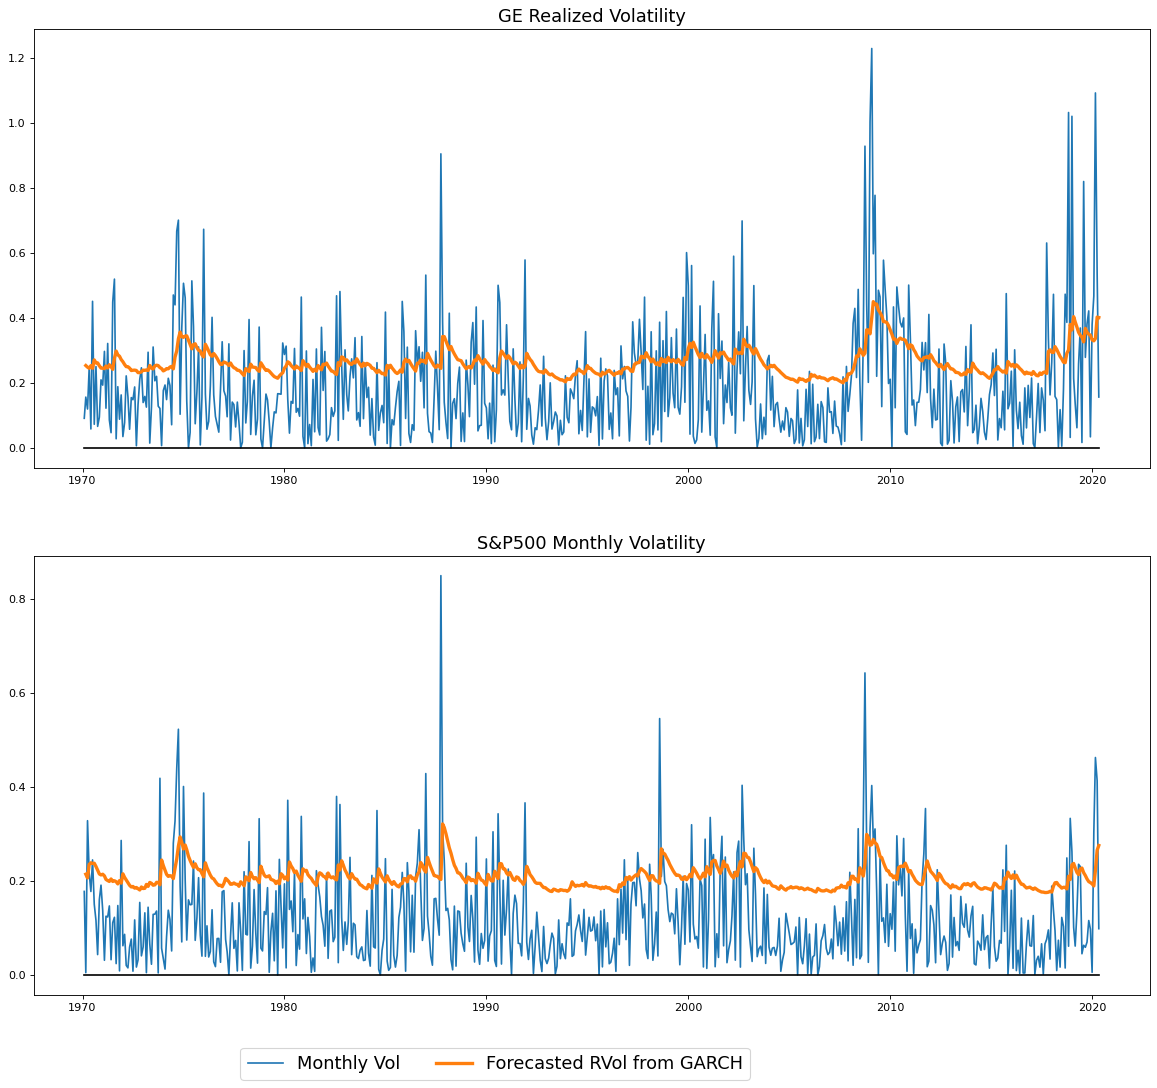

In [26]:

# plot them over time
fig,ax =  plt.subplots(2,1,figsize=(18, 16), dpi= 80)
ax[0].plot(df_monthly.index,df_monthly['GE^2']**(0.5),label='Monthly Vol')
ax[0].plot(res_GE.conditional_volatility**(0.5),label='Forecasted RVol from GARCH',linewidth=3)
ax[0].plot(df_monthly.index,0*df_monthly['GE^2'],color='black',label = '_nolegend_')
ax[0].set_title('GE Realized Volatility',fontsize=16)
ax[1].plot(df_monthly.index,df_monthly['SP500^2']**(0.5),label='Monthly Vol')
ax[1].plot(res_SP.conditional_volatility**(0.5),label='Forecasted RVol from GARCH',linewidth=3)
ax[1].plot(df_monthly.index,0*df_monthly['SP500^2'],color='black',label = '_nolegend_')
ax[1].set_title('S&P500 Monthly Volatility',fontsize=16)

ax[1].legend(bbox_to_anchor=(0.65, -0.1),ncol=2,fontsize=16)
plt.show()

> *As can be seen the GARCH volatility has the same issues as the ARCH:*
> 1. *It is on average above the RVol measure*
> 2. *It is appropriately persistent relative to Rvol -- just at a higher mean*
>
> *However the fit for GE is not too bad!*

In [27]:
resid_GE = np.matrix(df_monthly['GE^2']-res_GE.conditional_volatility)
resid_SP = np.matrix(df_monthly['SP500^2']-res_SP.conditional_volatility)
resid_GE=resid_GE[:,2:]
resid_SP=resid_SP[:,2:]

RMSE_GE_Garch=np.sqrt(resid_GE@resid_GE.T/np.max(np.shape(resid_GE)))
RMSE_SP_Garch=np.sqrt(resid_SP@resid_SP.T/np.max(np.shape(resid_SP)))

MAE_GE_Garch = np.mean(np.abs(resid_GE))
MAE_SP_Garch = np.mean(np.abs(resid_SP))

print('RMSE_GE','   RMSE_SP')
print('{:.4f}'.format(RMSE_GE_Garch.A1[0]),'    {:.4f}'.format(RMSE_SP_Garch.A1[0]))

RMSE_GE    RMSE_SP
0.1330     0.0513


>*Big differences in RMSE! And so much smaller than ARCH!*

In [28]:
def selectGarch(data,variable,maxLags):
    bic = np.zeros((maxLags+1,maxLags+1))
    aic = np.zeros((maxLags+1,maxLags+1))
    
    for p in range(1,maxLags+1):
        for q in range(1,maxLags+1):
            # run GARCH
            am = arc.arch_model(data[variable],vol='Garch',p=p,q=q,dist='normal',mean='ARX',lags=[1])
            res=am.fit()
            
            #store aic and bic
            bic[p,q] = res.bic
            aic[p,q] = res.aic

    p_b = np.argmin(np.min(bic,axis=1),axis=0)
    q_b=np.argmin(bic[p,:])
    
    p_a = np.argmin(np.min(aic,axis=1),axis=0)
    q_a=np.argmin(aic[p,:])
    
    
    return p_a,q_a,p_b,q_b,aic,bic
    

In [29]:
%%capture
p_a,q_a,p_b,q_b,aic,bic=selectGarch(df_monthly,'SP500',5)

In [30]:
pd.DataFrame(bic)

,0,1,2,3,4,5
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,-2066.667152,-2058.837832,-2057.748802,-2050.249805,-2044.945004
2,0.0,-2064.522686,-2059.339749,-2052.937829,-2045.501115,-2040.133968
3,0.0,-2058.208889,-2053.570411,-2054.617758,-2048.215842,-2041.813923
4,0.0,-2051.806971,-2047.168490,-2048.215842,-2041.813906,-2030.373121
5,0.0,-2045.405056,-2040.766576,-2041.813911,-2032.000736,-2023.971245


In [31]:
print(p_b,q_b)

1 1


In [32]:
pd.DataFrame(aic)

,0,1,2,3,4,5
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,-2088.676738,-2085.249335,-2088.562223,-2085.465142,-2084.562259
2,0.0,-2090.934189,-2090.153169,-2088.153166,-2085.118370,-2084.153140
3,0.0,-2089.022309,-2088.785748,-2094.235013,-2092.235014,-2090.235012
4,0.0,-2087.022309,-2086.785744,-2092.235014,-2090.234995,-2083.196127
5,0.0,-2085.022311,-2084.785748,-2090.235001,-2084.823743,-2081.196168


In [33]:
print(p_a,q_a)

3 3


In [34]:
%%capture
p_a,q_a,p_b,q_b,aic,bic=selectGarch(df_monthly,'GE',5)

In [35]:
pd.DataFrame(bic)

,0,1,2,3,4,5
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,-1506.326940,-1499.925016,-1493.523106,-1487.144944,-1480.911909
2,0.0,-1500.838582,-1494.476344,-1488.463404,-1483.030575,-1478.087753
3,0.0,-1494.436665,-1494.302037,-1487.266868,-1484.043099,-1477.641182
4,0.0,-1488.034748,-1487.900112,-1480.864951,-1477.641171,-1471.239265
5,0.0,-1481.632831,-1481.498202,-1474.463034,-1471.239209,-1464.837347


In [36]:
print(p_b,q_b)

1 1


In [37]:
pd.DataFrame(aic)

,0,1,2,3,4,5
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,-1528.336526,-1526.336519,-1524.336527,-1522.360281,-1520.529164
2,0.0,-1527.250085,-1525.289764,-1523.678742,-1522.647830,-1522.106925
3,0.0,-1525.250085,-1529.517375,-1526.884123,-1528.062271,-1526.062271
4,0.0,-1523.250086,-1527.517367,-1524.884123,-1526.062260,-1524.062271
5,0.0,-1521.250086,-1525.517374,-1522.884123,-1524.062216,-1522.062270


In [38]:
print(p_a,q_a)

3 2


# Question 3

In [39]:
%%capture
am = arc.arch_model(df_monthly['SP500'],vol='Garch',p=1,q=1,o=1,dist='normal',mean='ARX',lags=[1])
res_SP_O=am.fit()

am = arc.arch_model(df_monthly['GE'],vol='Garch',p=1,q=1,o=1,dist='normal',mean='ARX',lags=[1])
res_GE_O=am.fit()


In [43]:
print(res_SP_O.summary())
print('*******************************************************')
print(res_GE_O.summary())

                         AR - GJR-GARCH Model Results                         
Dep. Variable:                  SP500   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:                1056.13
Distribution:                  Normal   AIC:                          -2100.25
Method:            Maximum Likelihood   BIC:                          -2073.84
                                        No. Observations:                  603
Date:                Thu, May 14 2020   Df Residuals:                      597
Time:                        15:58:07   Df Model:                            6
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      5.7863e-03  1.974e-03      2.931  3.382e-03 [1.

> *$\gamma$ is the parameter on negative shock realizations while it is statistically significant the $\alpha$ coefficients are not. This is very surprising as it means only negative shocks change volatility. Weird*

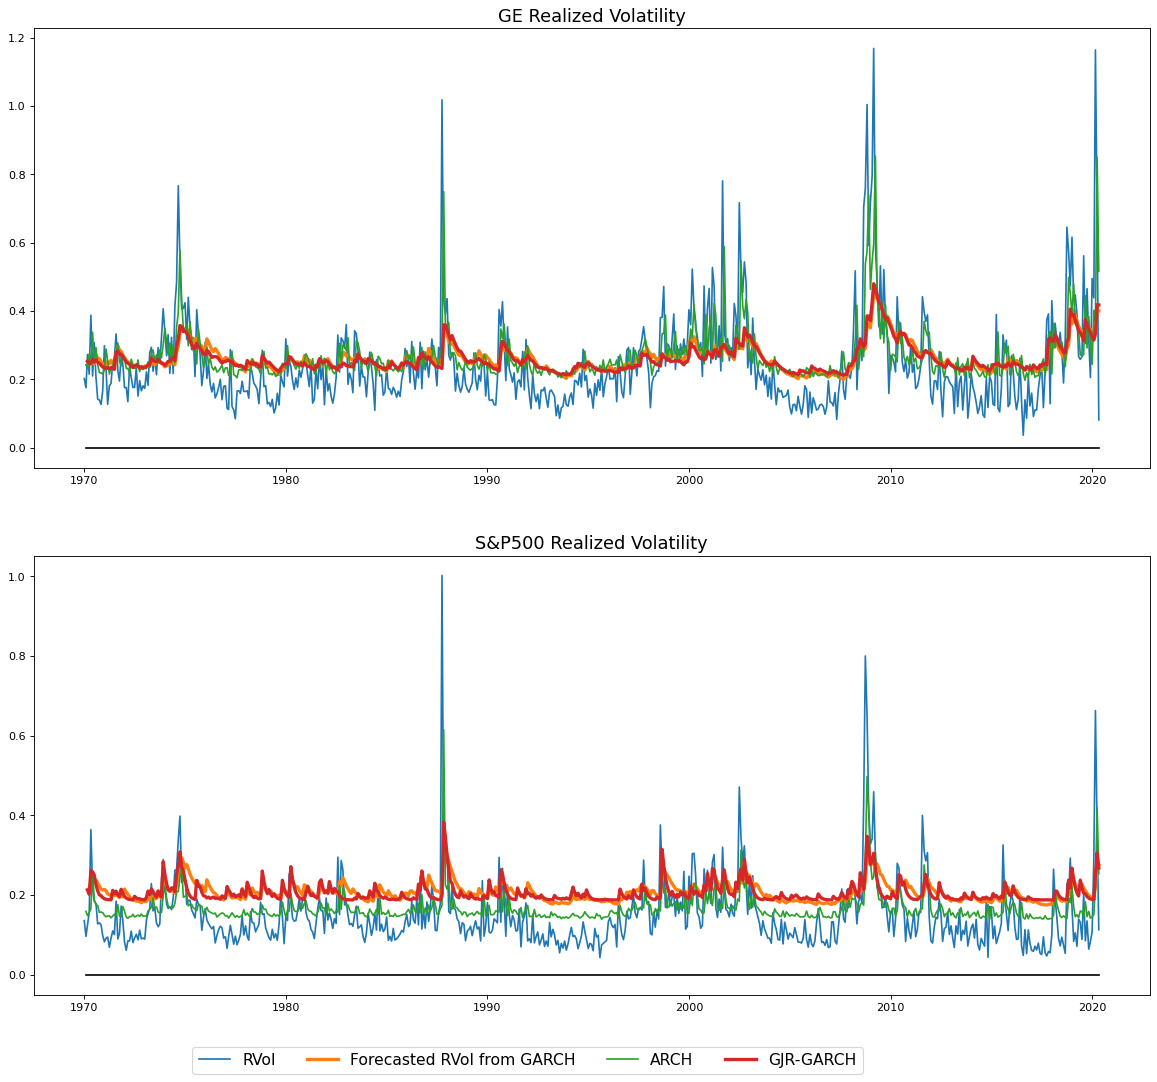

In [44]:
# plot them over time
fig,ax =  plt.subplots(2,1,figsize=(18, 16), dpi= 80)
ax[0].plot(df_RealizedVol.index,df_RealizedVol['GE^2']**(0.5),label='RVol')
ax[0].plot(res_GE.conditional_volatility**(0.5),label='Forecasted RVol from GARCH',linewidth=3)
ax[0].plot(df_monthly.index,(np.matrix(X_GE)@np.matrix(β_GE).T).A1**(0.5),label='ARCH')
ax[0].plot(res_GE_O.conditional_volatility**(0.5),label='GJR-GARCH',linewidth=3)
ax[0].plot(df_monthly.index,0*df_monthly['GE^2'],color='black',label = '_nolegend_')
ax[0].set_title('GE Realized Volatility',fontsize=16)
ax[1].plot(df_RealizedVol.index,df_RealizedVol['SP500^2']**(0.5),label='RVol')
ax[1].plot(res_SP.conditional_volatility**(0.5),label='Forecasted RVol from GARCH',linewidth=3)
ax[1].plot(df_monthly.index,(np.matrix(X_SP)@np.matrix(β_SP).T).A1**(0.5),label='ARCH')
ax[1].plot(res_SP_O.conditional_volatility**(0.5),label='GJR-GARCH',linewidth=3)
ax[1].plot(df_monthly.index,0*df_monthly['SP500^2'],color='black',label = '_nolegend_')
ax[1].set_title('S&P500 Realized Volatility',fontsize=16)

ax[1].legend(bbox_to_anchor=(0.75, -0.1),ncol=4,fontsize=14)
plt.show()

> *While the specification for the S&P500 clearly prefers the GJR term, you can see the conditional volatility fit is basically unchanged from GARCH. Hence Prof. Lettau's comment to evaluate these with forecasts. Note also the fit from the ARCH looks way better that all other models! Weird!*

In [46]:
def selectGJRGarch(data,variable,maxLags):
    bic = np.zeros((maxLags+1,maxLags+1,maxLags+1))
    aic = np.zeros((maxLags+1,maxLags+1,maxLags+1))
    
    for p in range(1,maxLags+1):
        for q in range(1,maxLags+1):
            for o in range(0,maxLags+1):
                # run GJR-GARCH
                am = arc.arch_model(data[variable],vol='Garch',p=p,q=q,o=o,dist='normal',mean='ARX',lags=[1])
                res=am.fit()
            
                #store aic and bic
                bic[p,q,o] = res.bic
                aic[p,q,o] = res.aic

    p_b = np.argmin(np.min(np.min(bic,axis=2),axis=1),axis=0)
    q_b=np.argmin(np.min(bic[p,:,:],axis=1))
    o_b=np.argmin(bic[p,q,:])
    
    p_a = np.argmin(np.min(np.min(aic,axis=2),axis=1),axis=0)
    q_a=np.argmin(np.min(aic[p,:,:],axis=1))
    o_a=np.argmin(aic[p,q,:])
    
    
    return p_a,q_a,o_a,p_b,q_b,o_b,aic,bic
%%capture
p_a,q_a,o_a,p_b,q_b,o_b,aic,bic=selectGJRGarch(df_monthly,'GE',5)


SyntaxError: invalid syntax (<ipython-input-46-f6edec67c91d>, line 26)

In [ ]:
print('GE')
print('bic',p_b,q_b,o_b)
print('aic',p_a,q_a,o_a)

In [ ]:
%%capture
p_a,q_a,o_a,p_b,q_b,o_b,aic,bic=selectGJRGarch(df_monthly,'SP500',5)

In [40]:
print('SP500')
print('bic',p_b,q_b,o_b)
print('aic',p_a,q_a,o_a)

SP500
bic 1 3 1
aic 3 3 3


In [ ]:
resid_GE_O = np.matrix(df_monthly['GE^2']-res_GE_O.conditional_volatility)
resid_SP_O = np.matrix(df_monthly['SP500^2']-res_SP_O.conditional_volatility)
resid_GE_O=resid_GE_O[:,2:]
resid_SP_O=resid_SP_O[:,2:]

RMSE_GE_GJRGarch=np.sqrt(resid_GE_O@resid_GE_O.T/np.max(np.shape((resid_GE_O))))
RMSE_SP_GJRGarch=np.sqrt(resid_SP_O@resid_SP_O.T/np.max(np.shape(resid_SP_O)))

MAE_GE_GJRGarch = np.mean(np.abs(resid_GE_O))
MAE_SP_GJRGarch = np.mean(np.abs(resid_SP_O))

print('           RMSE_GE','   RMSE_SP')
print('ARCH:      {:.4f}'.format(RMSE_GE.A1[0]),'    {:.4f}'.format(RMSE_SP.A1[0]*np.sqrt(12)))
print('GARCH:     {:.4f}'.format(RMSE_GE_Garch.A1[0]),'    {:.4f}'.format(RMSE_SP_Garch.A1[0]*np.sqrt(12)))
print('GJR-GARCH: {:.4f}'.format(RMSE_GE_GJRGarch.A1[0]),'    {:.4f}'.format(RMSE_SP_GJRGarch.A1[0]*np.sqrt(12)))

In [ ]:
print('           MAE_GE','   MAE_SP')
print('ARCH:      {:.4f}'.format(MAE_GE),'    {:.4f}'.format(MAE_SP))
print('GARCH:     {:.4f}'.format(MAE_GE_Garch),'    {:.4f}'.format(MAE_SP_Garch))
print('GJR-GARCH: {:.4f}'.format(MAE_GE_GJRGarch),'    {:.4f}'.format(MAE_SP_GJRGarch))

> *Ok, looks like the ARCH performs best. Makes sense given what we saw on the graph. Weird given that the other models nest and ARCH(1) and yet were fitted to get very different results!*